<div style="
    background-color: #393E46;
    border-radius:  12px 12px;
    text-align: center;
    padding: 15px;
    margin: 10px 0;
">
    <span style="
        font-family: 'Comic Sans MS', 'Comic Neue', cursive;
        font-size: 28px;
        font-weight: bold;
        padding: 5px 15px;
        border-radius: 5px;
        color: #fff;
    ">
         Load & Preprocess the data
    </span>
</div>


In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2DTranspose, BatchNormalization, ReLU, Conv2D, UpSampling2D, MaxPool2D, Dropout, MaxPooling2D, concatenate
from keras import Input, Model
import tensorflow as tf
import keras

from warnings import filterwarnings
filterwarnings('ignore')

In [40]:
import kagglehub

data_path = kagglehub.dataset_download("khaledzakarya/brain-tumar-dataset")

print("Path to dataset files:", data_path)

Path to dataset files: /kaggle/input/brain-tumar-dataset


In [41]:
temp = os.path.join(data_path , os.listdir(data_path)[0])
path = os.path.join(temp , 'Tumor')

In [42]:
def Dataset(path):

    img_names = os.listdir(path)
    df = pd.DataFrame()
    df['img_name'] = img_names
    df['img_name_mask'] = img_names
    for idx, name in enumerate(img_names):

        img_name = path +'/'+ name
        img_name_mask =path+'_masks/'+name.replace('jp','pn')

        df['img_name'].iloc[idx] = img_name
        df['img_name_mask'].iloc[idx] = img_name_mask
    return df

In [43]:
df_train = Dataset(os.path.join(path,'TRAIN'))
df_test = Dataset(os.path.join(path,'TEST'))

In [44]:
df_train.shape, df_test.shape

((500, 2), (100, 2))

<div style="
    background-color: #393E46;
    border-radius:  12px 12px;
    text-align: center;
    padding: 15px;
    margin: 10px 0;
">
    <span style="
        font-family: 'Comic Sans MS', 'Comic Neue', cursive;
        font-size: 28px;
        font-weight: bold;
        padding: 5px 15px;
        border-radius: 5px;
        color: #fff;
    ">
         Visualize Random Samples
    </span>
</div>


In [45]:
def visualize_random_sample(df, num_samples=12, image_size=(224, 224)):

    fig, axs = plt.subplots(num_samples, 2, figsize=(20, 5 * num_samples))

    for i in range(num_samples):
        img = cv2.imread(df.img_name[i])
        mask = cv2.imread(df.img_name_mask[i], cv2.IMREAD_GRAYSCALE)

        img_resized = cv2.resize(img, image_size)
        mask_resized = cv2.resize(mask, image_size)

        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

        img_with_mask = img_resized.copy()

        axs[i][0].imshow(img_rgb)
        axs[i][0].set_title("Brain MRI")
        axs[i][0].axis("off")

        axs[i][1].imshow(mask_resized, cmap='gray')
        axs[i][1].set_title("Mask")
        axs[i][1].axis("off")

    fig.tight_layout()
    plt.show()

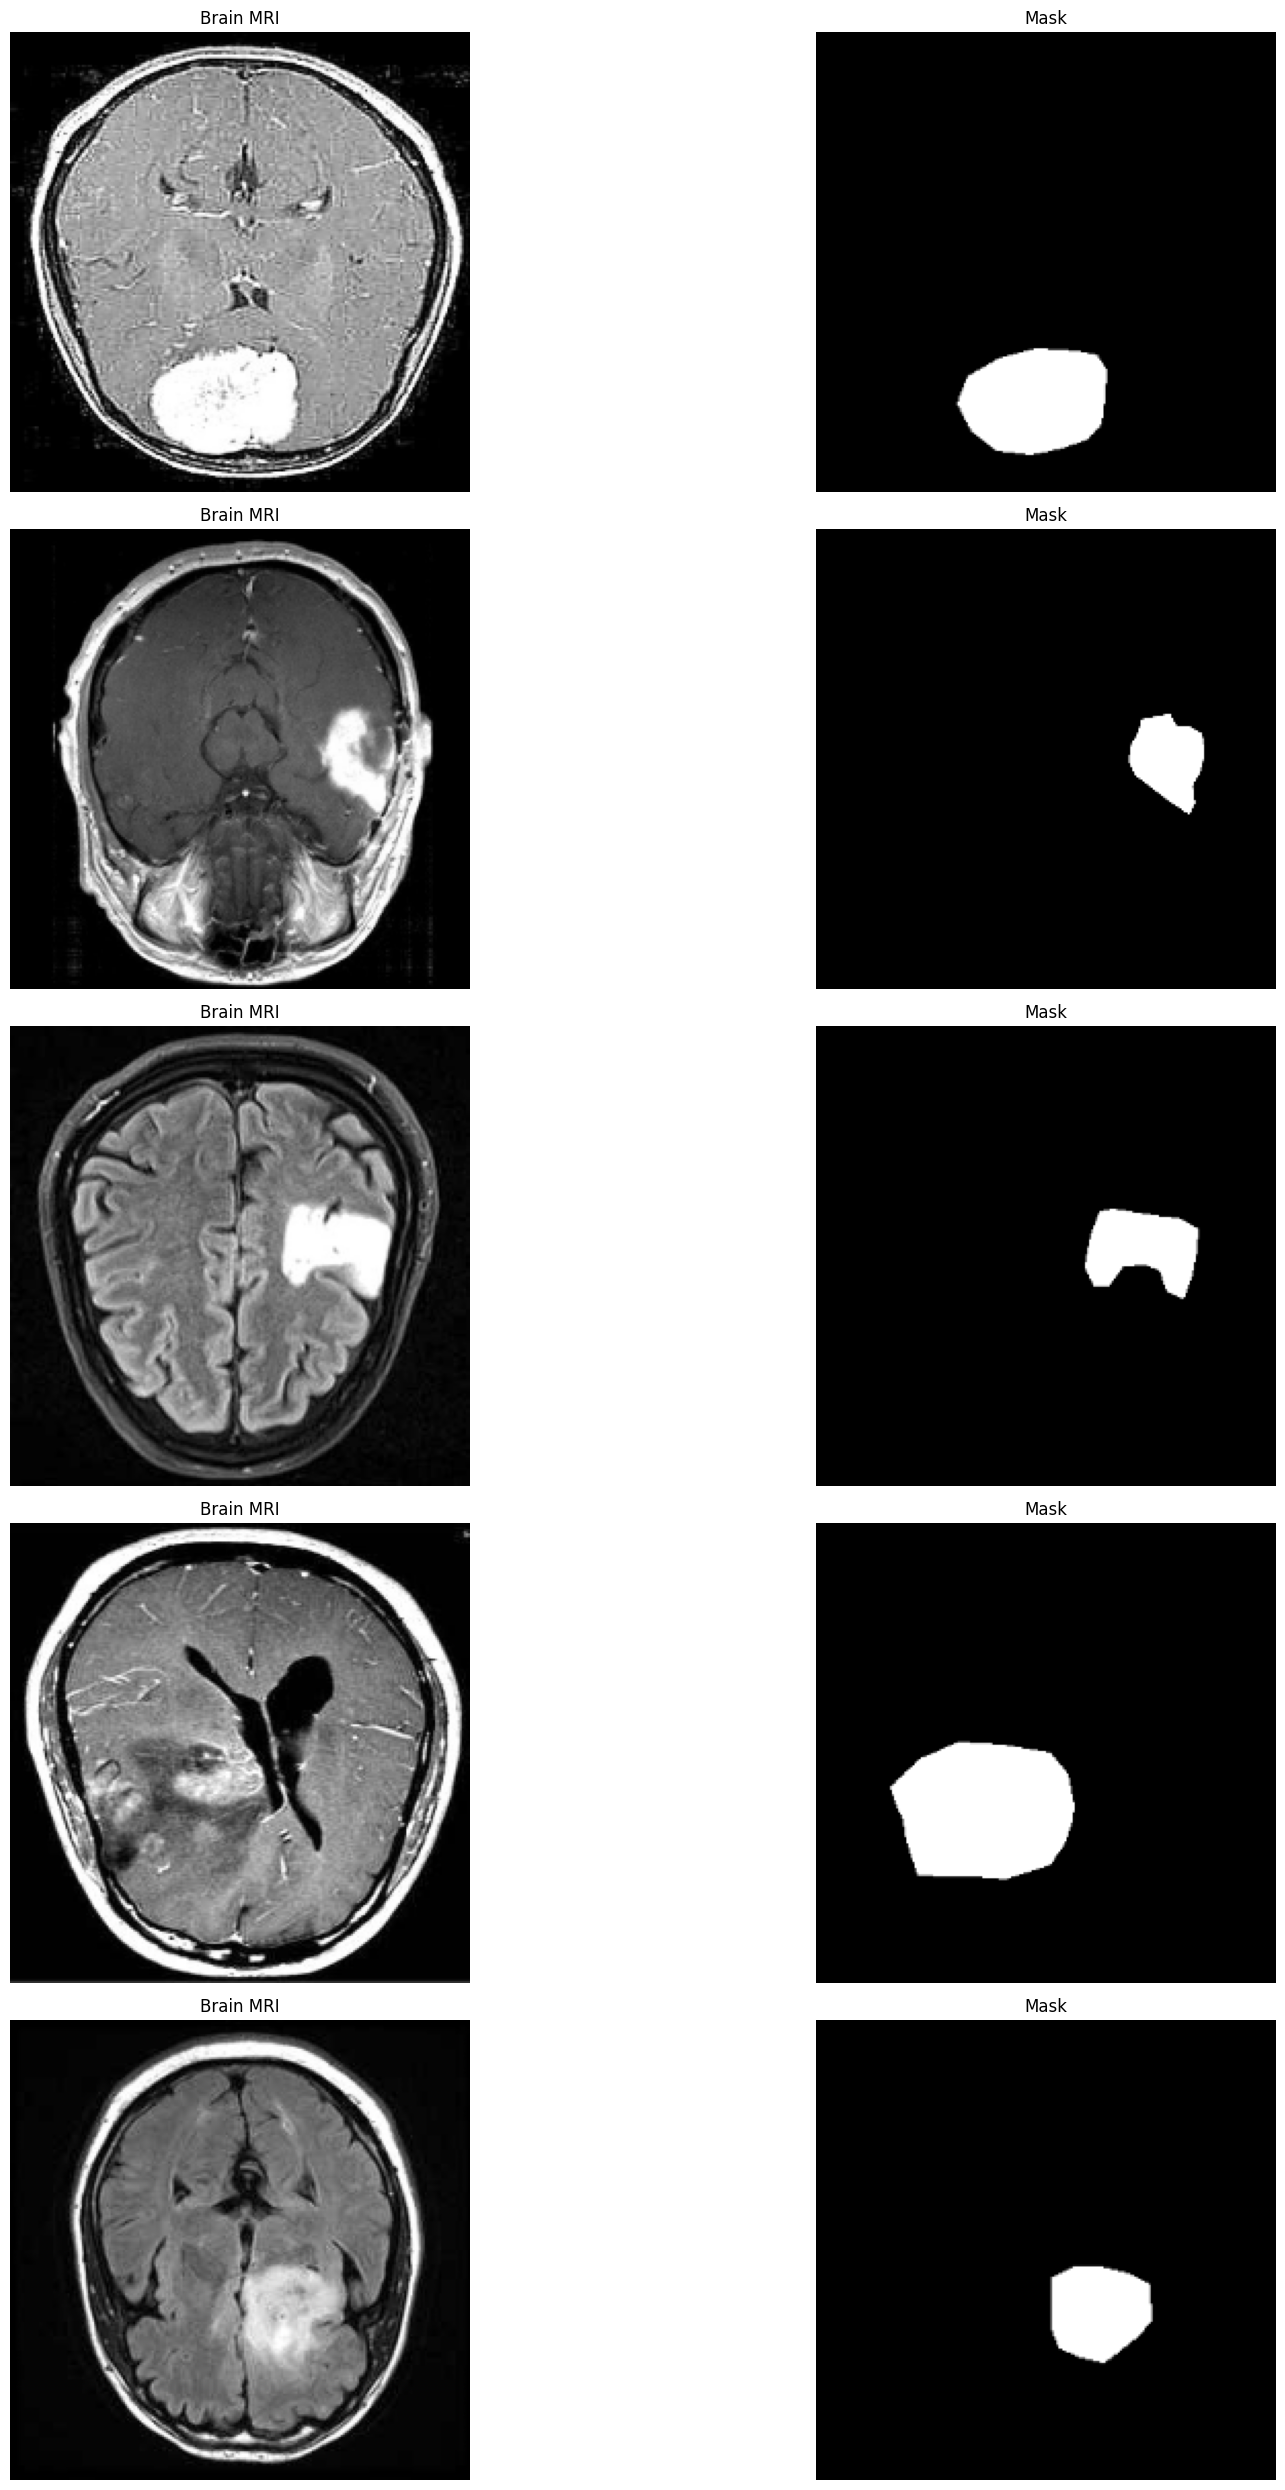

In [46]:
visualize_random_sample(df_train, num_samples=5)

In [47]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):
    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]
    list_ids = [self.ids[i] for i in indexes]
    list_mask = [self.mask[i] for i in indexes]

    X, y = self.__data_generation(list_ids, list_mask)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.ids))

    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    for i in range(len(list_ids)):
      img_path = str(list_ids[i])
      mask_path = str(list_mask[i])
      img =  cv2.imread(img_path, cv2.IMREAD_COLOR)
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)

      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      img = img /255
      mask = mask/255

      X[i,] = img
      y[i,] = np.expand_dims(mask, axis = 2)

    y = (y > 0).astype(int)
    return X, y

In [48]:
train_data = DataGenerator(df_train['img_name'], df_train['img_name_mask'],batch_size = 32, img_h = 224, img_w = 224, shuffle = True)
val_data = DataGenerator(df_test['img_name'], df_test['img_name_mask'],batch_size = 32, img_h = 224, img_w = 224, shuffle = False)

<div style="
    background-color: #393E46;
    border-radius:  12px 12px;
    text-align: center;
    padding: 15px;
    margin: 10px 0;
">
    <span style="
        font-family: 'Comic Sans MS', 'Comic Neue', cursive;
        font-size: 28px;
        font-weight: bold;
        padding: 5px 15px;
        border-radius: 5px;
        color: #fff;
    ">
         U-net Architecture
    </span>
</div>


In [49]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from skimage import io
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, ZeroPadding2D
from tensorflow.keras.applications import VGG19

In [50]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):

    inputs = Input(input_shape)


    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    s1 = vgg19.get_layer("block1_conv2").output
    s2 = vgg19.get_layer("block2_conv2").output
    s3 = vgg19.get_layer("block3_conv4").output
    s4 = vgg19.get_layer("block4_conv4").output
    b1 = vgg19.get_layer("block5_conv4").output


    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

In [51]:
model = build_vgg19_unet((224,224,3))
model.summary()

Model: "VGG19_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv4 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 28, 28, 256)    │              0 │ block3_conv4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 28, 28, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv4 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 14, 14, 512)    │              0 │ block4_conv4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 31,172,033 (118.91 MB)

 Trainable params: 31,168,193 (118.90 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [52]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [53]:
earlystopping = EarlyStopping(monitor='dice_coefficient',
                              mode='max', 
                              verbose=1, 
                              patience=30)
                              
reduce_lr = ReduceLROnPlateau(monitor='dice_coefficient',
                              mode='max',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2)

In [54]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coefficient,'accuracy'])

In [55]:
history = model.fit(train_data, 
                  epochs = 25, 
                  validation_data = val_data,
                  callbacks = [earlystopping, reduce_lr])          

Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7725 - dice_coefficient: 0.1368 - loss: 0.5210 - val_accuracy: 0.9446 - val_dice_coefficient: 1.8356e-05 - val_loss: 1.6389 - learning_rate: 0.0010
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9585 - dice_coefficient: 0.2126 - loss: 0.2254 - val_accuracy: 0.0567 - val_dice_coefficient: 0.1017 - val_loss: 17.8721 - learning_rate: 0.0010
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9603 - dice_coefficient: 0.2779 - loss: 0.1584 - val_accuracy: 0.0792 - val_dice_coefficient: 0.1061 - val_loss: 4.1317 - learning_rate: 0.0010
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9601 - dice_coefficient: 0.3214 - loss: 0.1369 - val_accuracy: 0.0621 - val_dice_coefficient: 0.1061 - val_loss: 4.2195 - learning_rate: 0.0010
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9591 - dice_coefficient: 0.3255 - loss: 0.1337 - val_accuracy: 0.2910 - val_dice_coefficient: 0.128

<div style="
    background-color: #393E46;
    border-radius:  12px 12px;
    text-align: center;
    padding: 15px;
    margin: 10px 0;
">
    <span style="
        font-family: 'Comic Sans MS', 'Comic Neue', cursive;
        font-size: 28px;
        font-weight: bold;
        padding: 5px 15px;
        border-radius: 5px;
        color: #fff;
    ">
         Evaluation
    </span>
</div>


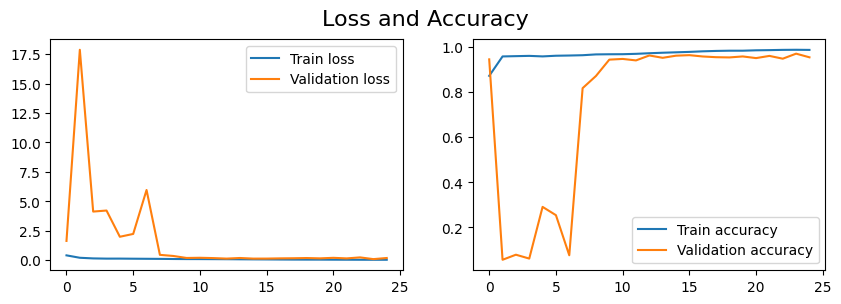

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

In [57]:
def visualize_predictions_from_generator(model, data_gen, num_samples=5):

    images, masks = next(iter(data_gen))

    indices = np.random.choice(len(images), num_samples, replace=False)

    fig, ax = plt.subplots(num_samples, 3, figsize=(10, 2.5 * num_samples))

    for i, idx in enumerate(indices):
        img = images[idx]
        true_mask = masks[idx].squeeze()
        pred_mask = model.predict(np.expand_dims(img, axis=0), verbose=0)[0].squeeze()


        ax[i, 0].imshow(img)
        ax[i, 0].set_title("Image")
        ax[i, 0].axis("off")

        ax[i, 1].imshow(true_mask, cmap='gray')
        ax[i, 1].set_title("True Mask")
        ax[i, 1].axis("off")

        ax[i, 2].imshow(pred_mask, cmap='gray')
        ax[i, 2].set_title("Prediction")
        ax[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


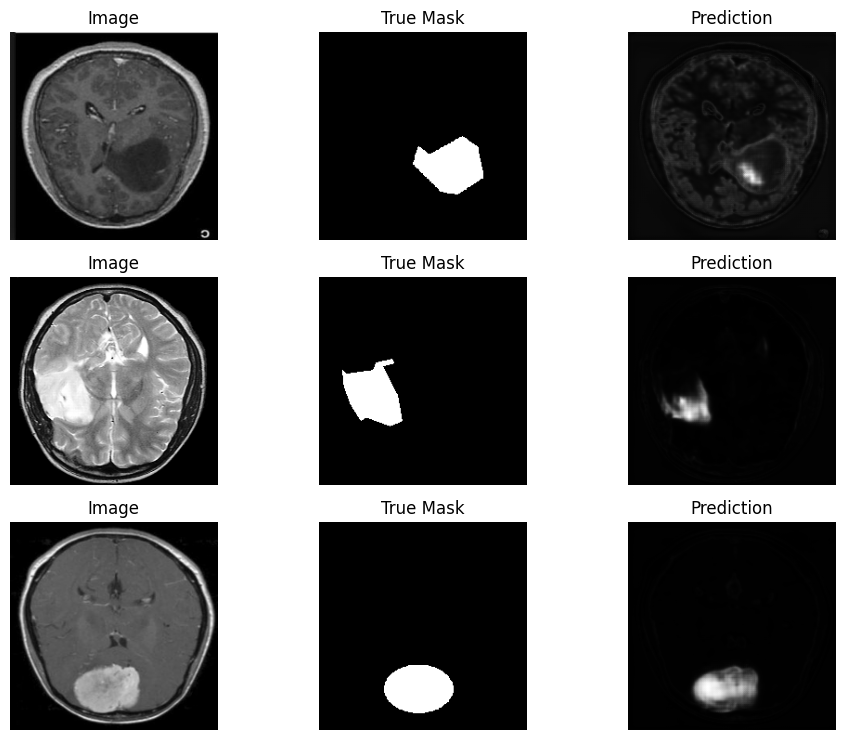

In [58]:
visualize_predictions_from_generator(model, val_data, num_samples=3)

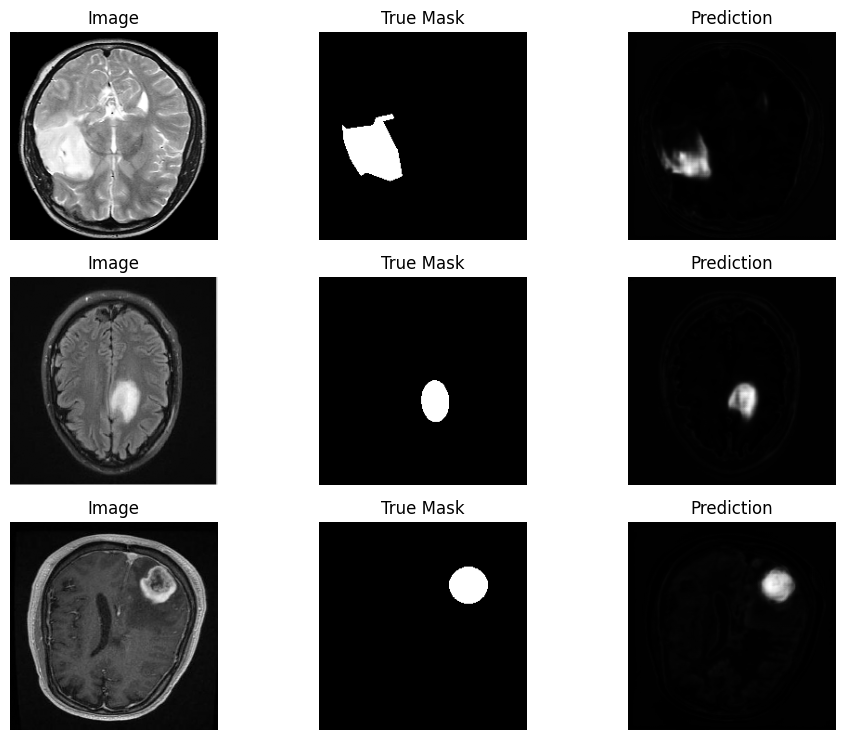

In [59]:
visualize_predictions_from_generator(model, val_data,3)

<div style="
    background-color: #393E46;
    border-radius:  12px 12px;
    text-align: center;
    padding: 15px;
    margin: 10px 0;
">
    <span style="
        font-family: 'Comic Sans MS', 'Comic Neue', cursive;
        font-size: 28px;
        font-weight: bold;
        padding: 5px 15px;
        border-radius: 5px;
        color: #fff;
    ">
         Saving Model
    </span>
</div>


In [60]:
model.save('final_brain_unet_model.h5')